# Linear models last time step prediction

In [1]:
import matplotlib.pyplot as plt
import json
import os
import datetime
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
data_dir = './vaccine_data/hhs_data/'

In [2]:
def convert_to_calender_data(week_offset_from_aug_1,year):
    '''Returns the calender Week'''
    d = "{}-W{}".format(year,week_offset_from_aug_1+31)
    r = datetime.datetime.strptime(d + '-0', "%Y-W%W-%w")
    r = r.strftime("%B %d, %Y")    
    return r

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

In [4]:
train_years = ['2013','2014']
dev_years = ['2015']
test_years = ['2016','2017']

train_download_dir = ('train',train_years)
dev_download_dir = ('dev',dev_years)
test_download_dir = ('test',test_years)
data_split_ls = [train_download_dir,dev_download_dir,test_download_dir]

# States 

In [66]:
## Plotting Year count trends year on year dev

def predict_state(state,threshold_start_pred):
    ### Plottting Code
    fig=plt.figure( dpi= 100)
    for data_split in data_split_ls:
        split,years = data_split
        for year in years:
            data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
            data['percentage']=data['percentage']
            # data = data[['week','count','percentage','disparity','week_start']]
            count_vaccinated_week = (data['percentage']*data['count']).values
            count_vaccinated_week[1:]=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
            count_vaccinated_week[0]=0
            plt.plot(data['week'],count_vaccinated_week,label=state+"_"+year);
            print("Max Week => week_num {}, Date = {}".format(count_vaccinated_week.argmax(),convert_to_calender_data(count_vaccinated_week.argmax(),year)))
    plt.grid()
    plt.title("Vaccination for State {}".format(state))
    plt.xlabel('Weeks, starting from aug-1')
    plt.ylabel('People Vaccinated')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    ### Model Train Code

    split,train_years = train_download_dir
    Y = []
    X = []
    week_means=[]
    for year in train_years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
        percent_vaccinated_week = (data['percentage']).values
        week_means.append(percent_vaccinated_week)
    week_means=np.asarray(week_means).mean(axis=0)
    for year in train_years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
        percent_vaccinated_week = (data['percentage']).values
        percent_vaccinated_week = percent_vaccinated_week -  week_means

        initial_week_vals = [percent_vaccinated_week[i] for i in range(0,threshold_start_pred)]

        for i in range(threshold_start_pred,len(percent_vaccinated_week)):
            X.append([week_means[i]]+initial_week_vals)
            Y.append(percent_vaccinated_week[i])


    X = np.asarray(X)
    Y = np.asarray(Y)
    model = linear_model.LinearRegression()
    model.fit(X,Y)
    y_pred = model.predict(X)
    error = metrics.mean_squared_error(y_pred,Y)
    print("Error in last train prediction {} %".format(error*100 ))

    ## Dev Prediction

    split = 'dev'
    year = '2015'
    data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
    percent_vaccinated_week = (data['percentage']).values
    percent_vaccinated_week = percent_vaccinated_week -  week_means

    initial_week_vals = [percent_vaccinated_week[i] for i in range(0,threshold_start_pred)]
    Y = []
    X = []
    for i in range(threshold_start_pred,len(percent_vaccinated_week)):
        X.append([week_means[i]]+initial_week_vals)
        Y.append(percent_vaccinated_week[i])

    X = np.asarray(X)
    Y = np.asarray(Y)

    y_pred = model.predict(X)
    error = metrics.mean_squared_error(y_pred,Y)
    print("State: {} Error in last dev prediction {} %".format(state, error*100 ))

    ## Test Prediction

    split = 'test'
    years = ['2016','2017']
    for year in years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
        percent_vaccinated_week = (data['percentage']).values
        percent_vaccinated_week = percent_vaccinated_week -  week_means[0:len(percent_vaccinated_week)]

        initial_week_vals = [percent_vaccinated_week[i] for i in range(0,threshold_start_pred)]
        Y = []
        X = []
        for i in range(threshold_start_pred,len(percent_vaccinated_week)):
            X.append([week_means[i]]+initial_week_vals)
            Y.append(percent_vaccinated_week[i])

        X = np.asarray(X)
        Y = np.asarray(Y)
        y_pred = model.predict(X)
        print(Y)
        break
        error = metrics.mean_squared_error(y_pred,Y)
        print("State: {} Error in last test prediction {} %".format(state, error*100 ))

    print("State:{} Model Coeff {},".format(state,model.coef_))



In [67]:
y_pred

NameError: name 'y_pred' is not defined

In [68]:
states = ['WA','AK','CO','CT','NJ','MT']


----------
State = WA With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 9, Date = October 12, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


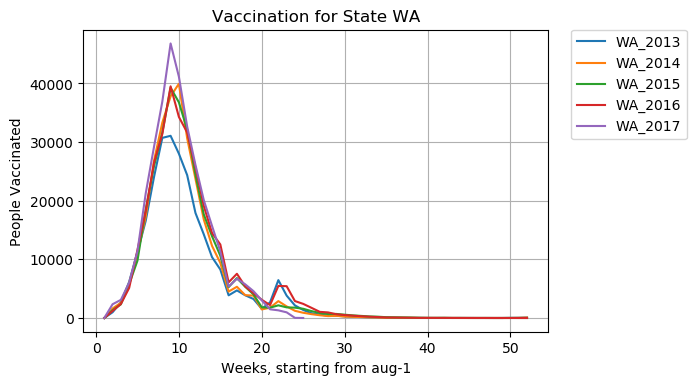

Error in last train prediction 0.001602764248753229 %
State: WA Error in last dev prediction 0.004561689233382542 %
[-4.29370e-03 -6.07045e-03 -7.74555e-03 -1.17483e-02 -1.97040e-02
 -1.94930e-02 -2.59985e-02 -2.56470e-02 -2.27910e-02 -2.07950e-02
 -1.85445e-02 -1.49385e-02 -1.30275e-02 -1.03545e-02 -8.98750e-03
 -8.68350e-03 -6.66400e-03 -7.22150e-03 -7.26650e-03 -4.25250e-03
 -2.89050e-03 -1.27100e-03  4.45000e-05  6.78500e-04  1.49600e-03
  1.79850e-03  2.09900e-03  2.36250e-03  2.52950e-03  2.67400e-03
  2.77800e-03  2.85400e-03  2.91400e-03  2.96100e-03  2.98550e-03
  2.99050e-03  3.00150e-03  3.01450e-03  3.02750e-03  3.03700e-03
  3.04250e-03  3.04900e-03  3.05400e-03  3.06100e-03  3.06700e-03
  3.06900e-03  3.05250e-03  3.00350e-03  2.87400e-03]
State:WA Model Coeff [-1.45367172e-17  1.17488030e+00  2.17611874e+00  1.35392456e+00],
----------
State = AK With first 3 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 7, Date = September 28, 2

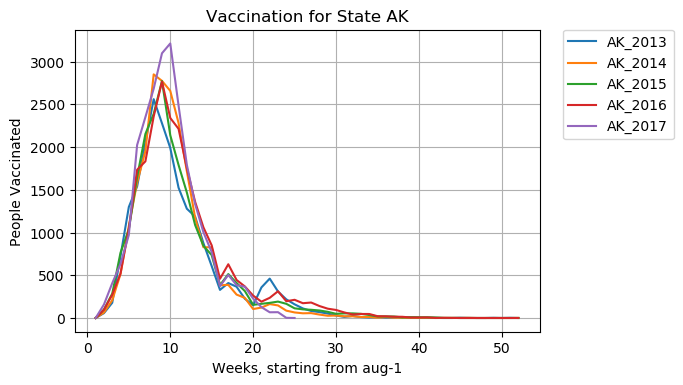

Error in last train prediction 0.001969544312655769 %
State: AK Error in last dev prediction 0.013957526754209549 %
[-0.0016799  -0.00660615 -0.00770775 -0.0148177  -0.025904   -0.0281235
 -0.032971   -0.0326275  -0.0322635  -0.0324375  -0.031442   -0.0311185
 -0.0304495  -0.02809    -0.0270835  -0.0256275  -0.024013   -0.025362
 -0.027285   -0.026673   -0.0264495  -0.0253145  -0.024254   -0.0228345
 -0.021753   -0.0208555  -0.019995   -0.0193395  -0.0191205  -0.0186405
 -0.0181175  -0.017927   -0.0177555  -0.017608   -0.0174925  -0.01744
 -0.017371   -0.0173215  -0.017315   -0.017295   -0.017289   -0.017323
 -0.0173475  -0.0173475  -0.0173475  -0.017365   -0.017365   -0.017382
 -0.01739   ]
State:AK Model Coeff [ 6.76142004e-18 -6.39667537e+00 -6.78079983e+00 -1.07207411e+01],
----------
State = CO With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => wee

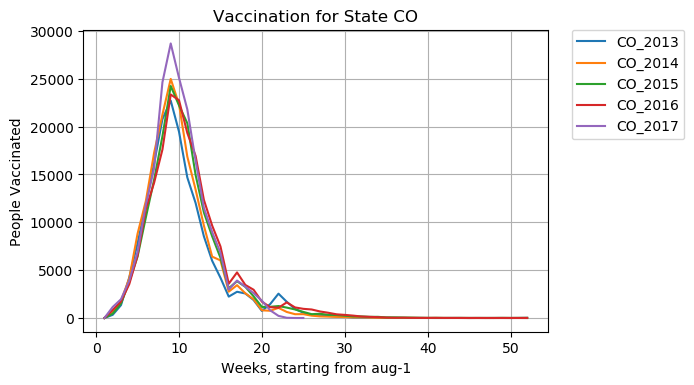

Error in last train prediction 0.0006066249807269906 %
State: CO Error in last dev prediction 0.05545306556482947 %
[-0.00268755 -0.0101114  -0.01608025 -0.028499   -0.044624   -0.054082
 -0.0563975  -0.0525685  -0.0460225  -0.0407315  -0.0339175  -0.0294725
 -0.0274995  -0.0241955  -0.022815   -0.020801   -0.018645   -0.019004
 -0.021613   -0.0208645  -0.0200085  -0.0189435  -0.0174775  -0.016377
 -0.0154875  -0.014908   -0.014397   -0.013938   -0.0137165  -0.013523
 -0.0133785  -0.013311   -0.0132845  -0.0132385  -0.0132425  -0.013245
 -0.013243   -0.013226   -0.013217   -0.01321    -0.013212   -0.0132165
 -0.013219   -0.0132185  -0.0132255  -0.0132315  -0.013231   -0.013249
 -0.0132995 ]
State:CO Model Coeff [-1.57832106e-17 -1.45009134e-01 -3.06899200e-01 -4.67074973e-01],
----------
State = CT With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week

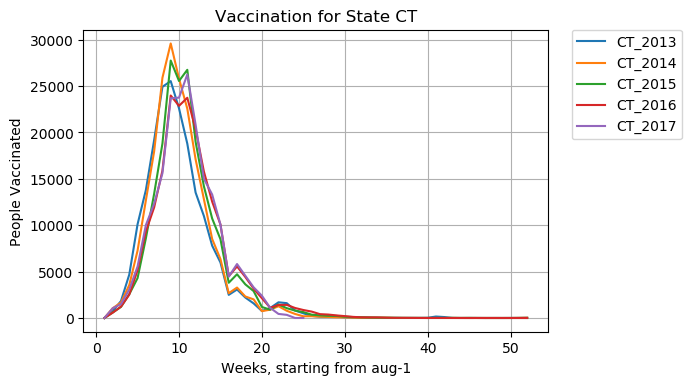

Error in last train prediction 0.0014190367199466891 %
State: CT Error in last dev prediction 0.0795347457496253 %
[-0.0077054  -0.01829485 -0.0302346  -0.050176   -0.0785315  -0.090695
 -0.0964035  -0.089742   -0.077187   -0.0675495  -0.0562305  -0.046062
 -0.0410535  -0.0347995  -0.029081   -0.025447   -0.0217075  -0.0214835
 -0.021838   -0.021358   -0.020171   -0.0188015  -0.0174975  -0.0167685
 -0.016068   -0.015617   -0.015269   -0.015055   -0.014949   -0.0148505
 -0.0147395  -0.0147065  -0.0146775  -0.014651   -0.0146535  -0.0146605
 -0.0146825  -0.014901   -0.0150365  -0.0150375  -0.015041   -0.0150455
 -0.0150515  -0.0150525  -0.0150535  -0.0150495  -0.0150525  -0.015082
 -0.015163  ]
State:CT Model Coeff [-3.89532861e-18  2.09344624e-02  4.07221490e-02  2.21100817e-02],
----------
State = NJ With first 3 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => 

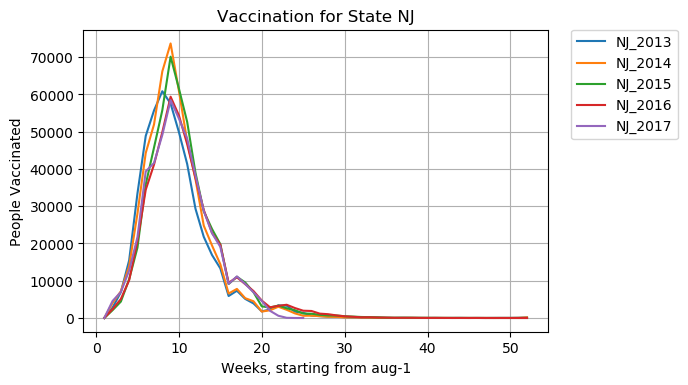

Error in last train prediction 0.0012261290234733442 %
State: NJ Error in last dev prediction 0.07703406625806036 %
[-0.00875535 -0.01964025 -0.032798   -0.046509   -0.061169   -0.067851
 -0.0691625  -0.066955   -0.062562   -0.0566995  -0.051908   -0.04593
 -0.042612   -0.03912    -0.0350975  -0.0319305  -0.0288845  -0.028191
 -0.028154   -0.027364   -0.026115   -0.025129   -0.0238295  -0.0231275
 -0.0224285  -0.0220515  -0.0217755  -0.0215985  -0.0215315  -0.0214545
 -0.021402   -0.0213435  -0.0213215  -0.021302   -0.021281   -0.021275
 -0.0212865  -0.02129    -0.0212885  -0.0212965  -0.0213055  -0.021312
 -0.021315   -0.021317   -0.0213285  -0.02134    -0.021357   -0.0214055
 -0.0215665 ]
State:NJ Model Coeff [1.39377269e-17 1.60396081e-01 2.65559972e-01 2.36799778e-01],
----------
State = MT With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num

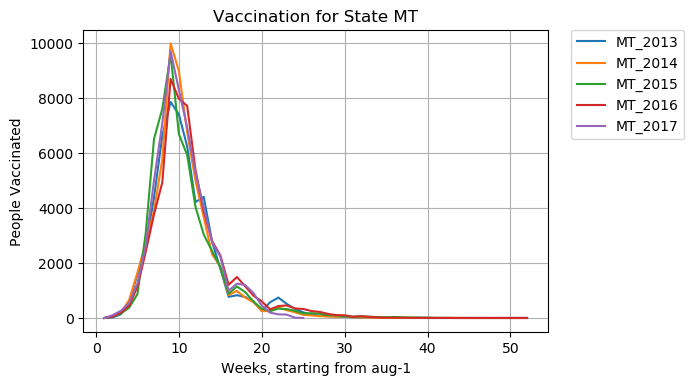

Error in last train prediction 0.000907818715871837 %
State: MT Error in last dev prediction 0.028538828795125266 %
[-0.00133594 -0.00560765 -0.0088892  -0.01371155 -0.026103   -0.03201
 -0.037549   -0.031964   -0.028545   -0.0317905  -0.031308   -0.0289935
 -0.0264545  -0.022677   -0.020169   -0.018857   -0.0164895  -0.017387
 -0.018611   -0.018434   -0.0180285  -0.0169095  -0.015917   -0.0149155
 -0.014329   -0.0139575  -0.013644   -0.0135045  -0.0131675  -0.0130035
 -0.012913   -0.012842   -0.012801   -0.012755   -0.0127195  -0.012709
 -0.012673   -0.0126665  -0.0126515  -0.012656   -0.0126675  -0.0126645
 -0.012668   -0.01266    -0.012664   -0.0126605  -0.0126645  -0.0126725
 -0.0126765 ]
State:MT Model Coeff [ 2.01637429e-18 -7.59434050e-01 -2.10840965e+00 -3.47718054e+00],


In [69]:
start_week = 3
for state in states:
    print("-"*10)
    print("State = {} With first {} weeks".format(state,start_week))
    print("-"*10)
    predict_state(state,start_week)

# First 4 weeks

----------
State = WA With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 9, Date = October 12, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


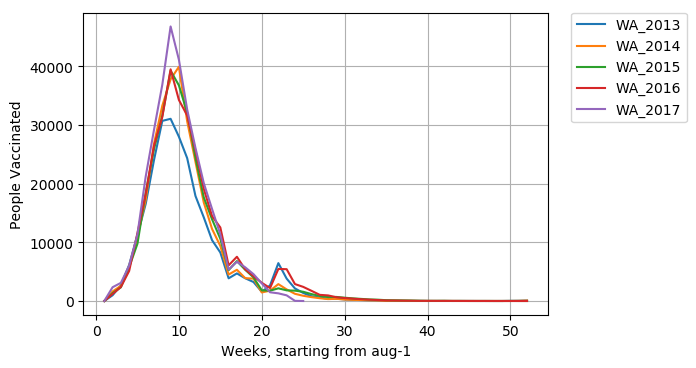

Error in last train prediction 0.00023547424441664301 %
State: WA Error in last dev prediction 0.004080705046846087 %
State: WA Error in last test prediction 0.0015202695555954343 %
State: WA Error in last test prediction 0.04406869103253201 %
State:WA Model Coeff [ 5.39591457e-05  1.14225421e+00  2.11568854e+00  1.31632646e+00
 -6.23379139e-01],
----------
State = AK With first 4 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 7, Date = September 28, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 9, Date = October 08, 2017


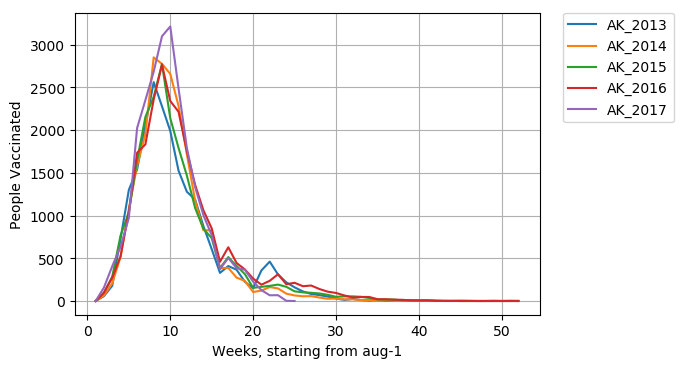

Error in last train prediction 0.02983223981756587 %
State: AK Error in last dev prediction 0.03186207208360625 %
State: AK Error in last test prediction 0.00537519401277708 %
State: AK Error in last test prediction 0.2741490930638617 %
State:AK Model Coeff [-1.39349865e-03 -1.74164227e-01 -1.84622901e-01 -2.91896881e-01
  2.32630871e+00],
----------
State = CO With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


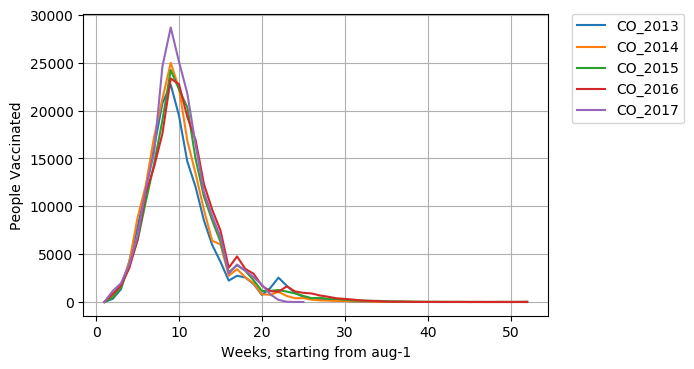

Error in last train prediction 0.001014530768513573 %
State: CO Error in last dev prediction 0.04493322007265186 %
State: CO Error in last test prediction 0.022322031229027175 %
State: CO Error in last test prediction 0.0966305041762001 %
State:CO Model Coeff [ 8.18684026e-05 -1.29056398e-01 -2.73136623e-01 -4.15691148e-01
 -2.07723864e-01],
----------
State = CT With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 10, Date = October 15, 2017


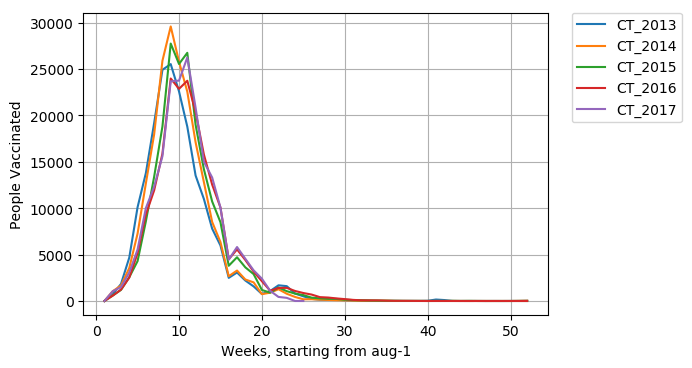

Error in last train prediction 0.011654526990502543 %
State: CT Error in last dev prediction 0.06840647406928115 %
State: CT Error in last test prediction 0.06984831209113977 %
State: CT Error in last test prediction 0.06042598167822388 %
State:CT Model Coeff [ 0.00073127  0.01083859  0.02108346  0.01144726 -0.03837968],
----------
State = NJ With first 4 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


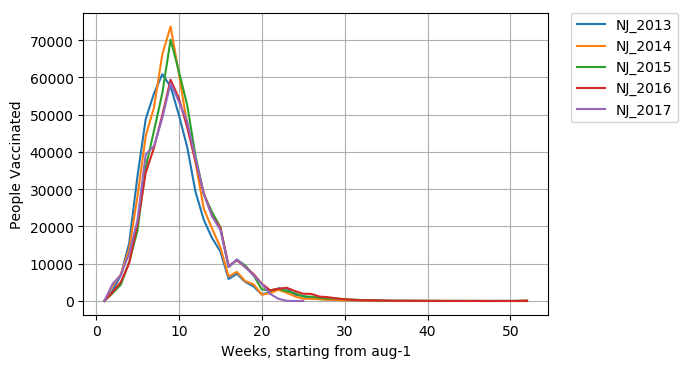

Error in last train prediction 0.00043601286727710717 %
State: NJ Error in last dev prediction 0.028364045635360425 %
State: NJ Error in last test prediction 0.035841284685570955 %
State: NJ Error in last test prediction 0.21622586145451528 %
State:NJ Model Coeff [-1.71049753e-04  1.62968531e-01  2.69819053e-01  2.40597599e-01
 -3.95824810e-02],
----------
State = MT With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


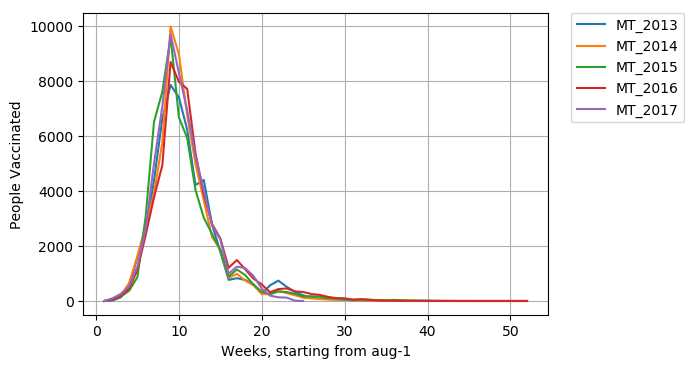

Error in last train prediction 5.9752060976973186e-06 %
State: MT Error in last dev prediction 0.03592561437337615 %
State: MT Error in last test prediction 0.016855587416621336 %
State: MT Error in last test prediction 0.07742087423021571 %
State:MT Model Coeff [-1.94592228e-04 -2.98636644e-01 -8.29102120e-01 -1.36735181e+00
 -2.06552500e+00],


In [76]:
start_week = 4
for state in states:
    print("-"*10)
    print("State = {} With first {} weeks".format(state,start_week))
    print("-"*10)
    predict_state(state,start_week)